In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

ModuleNotFoundError: ignored

In [ ]:
pd.options.display.float_format = '{:.3f}'.format

np.set_printoptions(suppress=True)

In [ ]:
path = r'/content/gdrive/MyDrive/bus' # use your path
all_files = glob.glob(path + "/*.csv")
all_files.sort()

In [ ]:
li_train = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame = pd.concat(li_train, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.000,7.000,10.000,10.000,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.000,7.000,7.000,10.000,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.000,8.000,7.000,7.000,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.000,8.000,8.000,7.000,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.000,10.000,8.000,8.000,151,68,0,0,0,2393


In [ ]:

frame.shape

(10639, 46)

# Dealing with Nan Values

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

100772

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,...,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000
mean,8.232,8.135,8.112,8.099,8.125,9984.640,9997.880,10013.592,10029.786,10047.591,...,5.161,5.043,5.007,5.019,183.025,183.238,183.468,183.705,183.951,9953.148
std,2.435,2.433,2.434,2.434,2.433,11372.752,11397.918,11422.153,11448.840,11484.282,...,6.734,6.708,6.700,6.703,193.709,194.036,194.337,194.660,195.046,10744.687
min,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,...,-15.000,-15.000,-15.000,-15.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.000,7.000,7.000,7.000,7.000,2124.000,2124.000,2124.000,2124.000,2124.000,...,1.000,1.000,1.000,1.000,48.000,48.000,48.000,48.000,48.000,2357.000
50%,8.301,8.000,8.000,7.992,8.000,5972.000,5972.000,5972.000,5983.000,5994.000,...,6.590,6.132,6.010,6.000,122.000,122.000,122.000,123.000,123.000,6347.000
75%,9.000,9.000,9.000,9.000,9.000,13946.000,13951.500,13980.000,14002.000,14018.500,...,7.000,7.000,7.000,7.000,256.000,256.000,256.000,256.000,257.000,13998.500
max,15.000,15.000,15.000,15.000,15.000,87872.000,87872.000,87872.000,87872.000,87872.000,...,32.000,32.000,32.000,32.000,2179.000,2179.000,2179.000,2179.000,2179.000,75533.000


In [ ]:
frame.isna().sum().sum()

0

In [ ]:
print(frame['DL_bitrate'].quantile(0.33))
print(frame['DL_bitrate'].quantile(0.66))

3378.08
10570.4


In [ ]:
frame_low = frame[frame['DL_bitrate']<=frame['DL_bitrate'].quantile(0.33)]
frame_medium = frame[(frame['DL_bitrate']>frame['DL_bitrate'].quantile(0.33)) & (frame['DL_bitrate']<=frame['DL_bitrate'].quantile(0.66))]
frame_high = frame[frame['DL_bitrate']>frame['DL_bitrate'].quantile(0.66)]

In [ ]:
frame_low.shape

(3511, 46)

In [ ]:
frame_medium.shape

(3511, 46)

In [ ]:
frame_high.shape

(3617, 46)

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

# Random Split

## Low Throughput

In [ ]:
frame_low_train = frame_low.sample(frac = 0.7, random_state=0)
frame_low_test = frame_low.drop(frame_low_train.index)

In [ ]:
frame_low_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
7788,5.000,5.000,6.000,6.000,7.000,2717.000,2549.000,5268.000,4607.000,4775.000,...,0.000,0.000,0.000,-1.000,50.000,47.000,98.000,85.000,88.000,3176.000
118,6.000,6.000,6.000,6.000,6.000,380.000,380.000,436.000,335.000,380.000,...,-5.000,-5.000,-5.000,-5.000,15.000,8.000,12.000,14.000,10.000,1041.000
2595,8.000,4.000,9.000,6.000,6.000,3.000,2.000,2.000,7.000,8.000,...,0.000,2.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,10.000
5025,8.407,8.092,8.049,7.995,8.090,2057.000,1957.000,2382.000,2001.000,2583.000,...,6.605,6.312,6.024,6.111,72.000,36.000,44.000,37.000,48.000,2552.000
7271,6.000,5.000,7.000,7.000,7.000,1453.000,1822.000,2426.000,2292.000,3165.000,...,3.000,3.000,3.000,3.000,71.000,34.000,45.000,37.000,59.000,2115.000


In [ ]:
frame_low_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.000,7.000,10.000,7.000,7.000,0.000,0.000,310.000,3.000,3.000,...,7.000,7.000,10.000,10.000,0.000,0.000,14.000,7.000,7.000,1769.000
3,9.000,7.000,7.000,7.000,7.000,1757.000,0.000,0.000,0.000,0.000,...,10.000,8.000,8.000,7.000,68.000,0.000,0.000,0.000,0.000,2674.000
7,7.000,8.000,9.000,9.000,9.000,1386.000,2516.000,2874.000,4216.000,1757.000,...,10.000,10.000,10.000,10.000,26.000,47.000,53.000,151.000,68.000,2357.000
12,7.000,7.000,7.000,9.000,7.000,3824.000,1107.000,1666.000,2807.000,2382.000,...,8.000,8.000,9.000,9.000,75.000,52.000,60.000,52.000,45.000,2218.000
21,7.000,9.000,9.000,9.000,9.000,100.000,313.000,1107.000,156.000,2169.000,...,7.000,9.000,9.000,10.000,5.000,12.000,30.000,5.000,69.000,650.000


In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(2458, 46)
(1053, 46)


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (1720, 15)
Validation set shape (738, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2152,0.357,0.357,0.357,0.357,0.357,0.308,0.154,0.041,0.182,0.176,0.353,0.324,0.324,0.412,0.412
1909,0.357,0.357,0.286,0.357,0.357,0.092,0.116,0.051,0.080,0.090,0.500,0.500,0.588,0.588,0.618
564,0.515,0.496,0.485,0.490,0.499,0.101,0.212,0.055,0.124,0.185,0.674,0.637,0.625,0.627,0.623
294,0.530,0.510,0.503,0.504,0.512,0.045,0.066,0.036,0.064,0.083,0.682,0.640,0.631,0.624,0.626
2404,0.520,0.496,0.493,0.488,0.496,0.000,0.000,0.000,0.000,0.000,0.679,0.639,0.623,0.621,0.619


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (1720, 15, 1)
Validation set shape (738, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


NameError: ignored

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

NameError: ignored

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 22s]
val_mean_absolute_error: 0.14153538644313812

Best val_mean_absolute_error So Far: 0.13622410595417023
Total elapsed time: 00h 13m 22s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 448
units2 480
units3 192
learning_rate 0.001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 448)               7168      
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 480)               215520    
                                                                 
 dropout_1 (Dropout)         (None, 480)               0         
                                                                 
 dense_2 (Dense)             (None, 192)               92352     
                                                                 
 dropout_2 (Dropout)         (None, 192)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.17590184292074842
Validation rmse: 0.18365042554318997


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.643,0.429,0.429,0.000,0.000,0.013,0.000,0.000,0.676,0.647,0.647,0.735,0.758
1,0.571,0.429,0.429,0.429,0.429,0.118,0.000,0.000,0.000,0.000,0.735,0.735,0.676,0.676,0.667
2,0.429,0.500,0.571,0.571,0.571,0.093,0.121,0.123,0.150,0.060,0.794,0.735,0.735,0.735,0.758
3,0.429,0.429,0.429,0.571,0.429,0.258,0.053,0.071,0.100,0.081,0.676,0.676,0.676,0.706,0.727
4,0.429,0.571,0.571,0.571,0.571,0.007,0.015,0.047,0.006,0.074,0.647,0.647,0.706,0.706,0.758


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

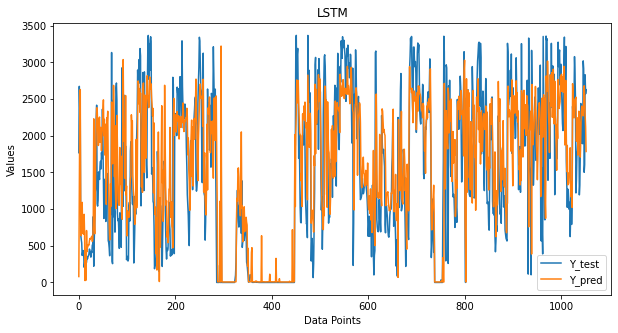

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

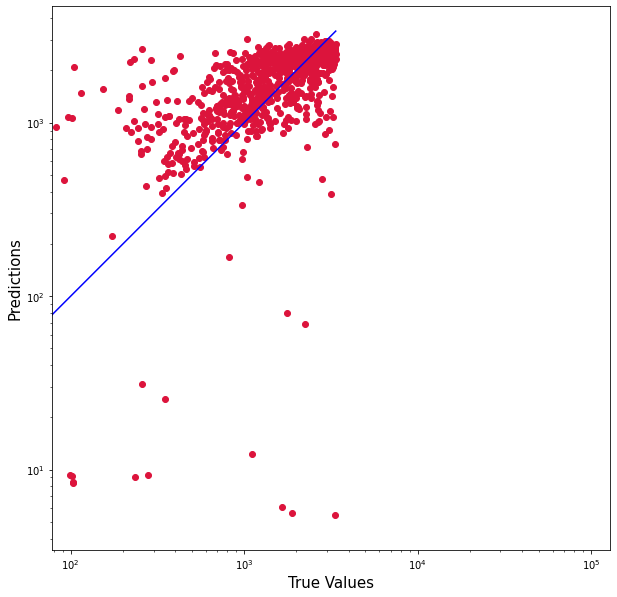

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

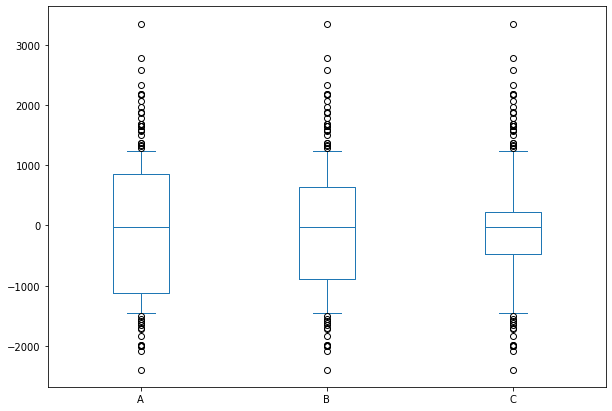

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(460.2502136230469, shape=(), dtype=float64)
Decimal Representation: 460.25021362304687500000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

3.379070060661638e+16
 33790700606616380.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.5919779251130692

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.5219254973150718

# Random Split

## Medium Throughput

In [ ]:
frame_medium_train = frame_medium.sample(frac = 0.7, random_state=0)
frame_medium_test = frame_medium.drop(frame_medium_train.index)

In [ ]:
frame_medium_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
9433,6.000,5.000,10.000,9.000,9.000,5368.000,5222.000,9036.000,10266.000,12794.000,...,2.000,2.000,3.000,3.000,94.000,85.000,161.000,146.000,219.000,5575.000
726,10.000,10.000,10.000,10.000,10.000,10356.000,8924.000,10960.000,8924.000,9439.000,...,8.000,8.000,6.000,6.000,193.000,164.000,245.000,165.000,218.000,10420.000
3946,8.407,8.074,8.039,7.964,8.059,3657.000,3053.000,4138.000,3288.000,3176.000,...,6.606,6.241,6.078,6.196,67.000,56.000,76.000,65.000,59.000,4417.000
7617,5.000,5.000,6.000,5.000,5.000,7806.000,9160.000,15638.000,14908.000,16899.000,...,2.000,2.000,5.000,5.000,144.000,169.000,296.000,275.000,313.000,9962.000
9003,7.927,7.805,7.840,8.097,8.266,4395.000,4697.000,7336.000,12973.000,15759.000,...,7.048,6.813,6.505,6.263,102.000,215.000,214.000,237.000,297.000,5233.000


In [ ]:
frame_medium_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
246,9.000,9.000,6.000,6.000,6.000,1308.000,1151.000,973.000,794.000,1017.000,...,2.000,1.000,1.000,-2.000,25.000,21.000,18.000,22.000,32.000,3777.000
249,9.000,9.000,9.000,9.000,9.000,3836.000,1532.000,1644.000,1308.000,1151.000,...,4.000,4.000,2.000,2.000,71.000,29.000,31.000,25.000,21.000,6305.000
253,8.000,8.000,8.000,8.000,9.000,6654.000,5334.000,5334.000,6542.000,3836.000,...,5.000,6.000,4.000,4.000,123.000,99.000,99.000,121.000,71.000,9738.000
258,8.000,8.000,8.000,8.000,8.000,12458.000,11508.000,9450.000,7616.000,7661.000,...,5.000,5.000,5.000,5.000,244.000,213.000,457.000,203.000,141.000,6083.000
286,8.000,8.000,8.000,6.000,6.000,8320.000,8130.000,6565.000,2225.000,0.000,...,-4.000,-4.000,-6.000,-6.000,171.000,151.000,121.000,70.000,0.000,8193.000


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (1720, 15)
Validation set shape (738, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2152,1.000,0.643,0.643,0.643,0.615,0.084,0.075,0.050,0.063,0.054,0.643,0.667,0.667,0.690,0.690
1909,0.514,0.501,0.502,0.488,0.445,0.092,0.118,0.145,0.089,0.063,0.554,0.521,0.498,0.497,0.490
564,0.429,0.429,0.429,0.429,0.385,0.219,0.143,0.144,0.264,0.238,0.357,0.429,0.429,0.333,0.333
294,0.714,0.714,0.714,0.714,0.692,0.146,0.081,0.070,0.046,0.044,0.595,0.595,0.548,0.548,0.595
2404,0.551,0.507,0.489,0.497,0.469,0.152,0.092,0.021,0.050,0.063,0.554,0.511,0.506,0.510,0.511


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (1720, 15, 1)
Validation set shape (738, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt1')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 22s]
val_mean_absolute_error: 0.17630411684513092

Best val_mean_absolute_error So Far: 0.1734086275100708
Total elapsed time: 00h 13m 34s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 384
units2 128
units3 480
learning_rate 0.01


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 384)               6144      
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               49280     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               61920     
                                                                 
 dropout_2 (Dropout)         (None, 480)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.2376229054661047
Validation rmse: 0.2316393635008263


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571,0.571,0.357,0.357,0.357,0.036,0.022,0.019,0.015,0.021,0.390,0.405,0.381,0.381,0.310
1,0.571,0.571,0.571,0.571,0.571,0.104,0.030,0.032,0.025,0.023,0.439,0.452,0.452,0.405,0.405
2,0.500,0.500,0.500,0.500,0.571,0.181,0.104,0.104,0.127,0.078,0.488,0.476,0.500,0.452,0.452
3,0.500,0.500,0.500,0.500,0.500,0.338,0.224,0.184,0.147,0.156,0.463,0.476,0.476,0.476,0.476
4,0.500,0.500,0.500,0.357,0.357,0.226,0.158,0.128,0.043,0.000,0.268,0.262,0.262,0.214,0.214


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

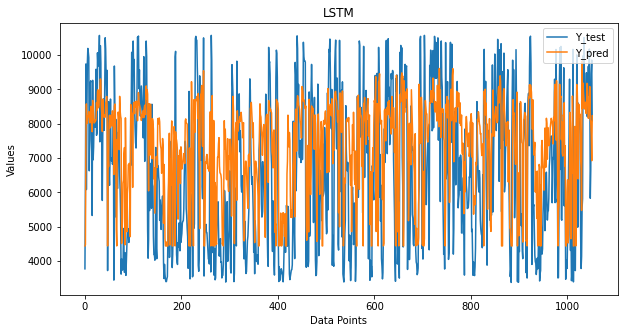

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

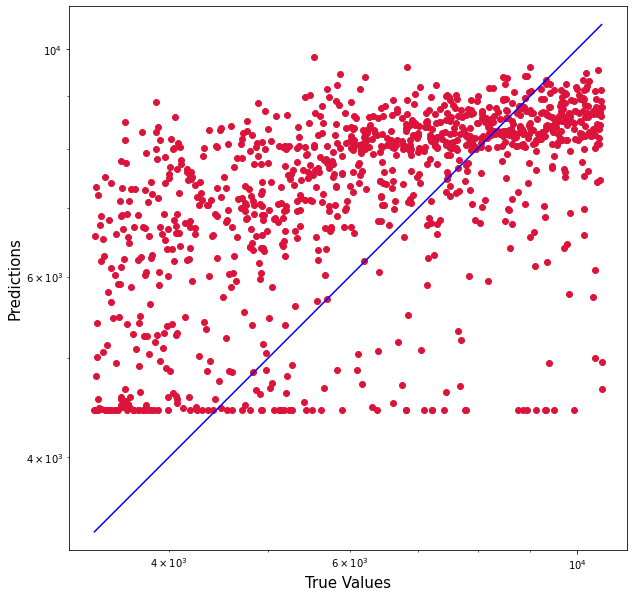

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

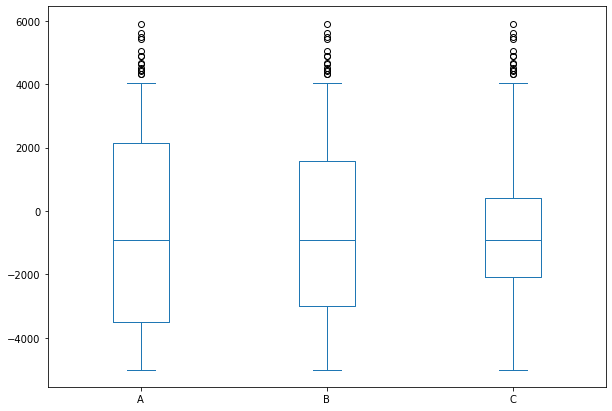

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,4443.285
1,4478.687
2,7596.584
3,8575.393
4,8004.188
...,...
1048,8108.692
1049,8063.120
1050,7661.653
1051,6921.408


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(1593.131103515625, shape=(), dtype=float64)
Decimal Representation: 1593.13110351562500000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.29213819580070116
 0.29214


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.1227728814572402

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.4917217345558724

## High Throughput

In [ ]:
frame_high_train = frame_high.sample(frac = 0.7, random_state=0)
frame_high_test = frame_high.drop(frame_high_train.index)

In [ ]:
frame_high_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
607,6.000,6.000,2.000,10.000,5.000,27233.000,19393.000,19393.000,15199.000,24492.000,...,0.000,-3.000,-3.000,-2.000,507.000,393.000,393.000,272.000,433.000,30567.000
7974,15.000,15.000,15.000,15.000,15.000,43774.000,30923.000,22054.000,16664.000,14662.000,...,28.000,28.000,28.000,28.000,806.000,569.000,407.000,304.000,264.000,29838.000
10123,7.000,11.000,7.000,8.000,6.000,11709.000,17950.000,19024.000,17357.000,12570.000,...,4.000,3.000,3.000,9.000,183.000,258.000,243.000,237.000,198.000,11586.000
7733,8.000,8.000,5.000,7.000,7.000,6598.000,12022.000,9226.000,9495.000,7649.000,...,-5.000,-5.000,6.000,6.000,121.000,223.000,170.000,179.000,142.000,10687.000
8571,11.000,5.000,6.000,6.000,6.000,8388.000,5726.000,12615.000,9361.000,7851.000,...,-2.000,-2.000,-3.000,-3.000,157.000,171.000,367.000,173.000,183.000,20526.000


In [ ]:
frame_high_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
351,9.000,9.000,8.000,8.000,8.000,4428.000,3970.000,4518.000,6990.000,8209.000,...,5.000,5.000,5.000,5.000,96.000,87.000,84.000,172.000,149.000,10989.000
354,9.000,10.000,10.000,9.000,9.000,7504.000,5424.000,5323.000,4428.000,3970.000,...,7.000,5.000,5.000,5.000,142.000,137.000,99.000,96.000,87.000,12004.000
373,15.000,12.000,10.000,10.000,2.000,10859.000,9774.000,7538.000,7538.000,7538.000,...,7.000,7.000,7.000,1.000,198.000,181.000,139.000,139.000,139.000,27845.000
378,2.000,10.000,10.000,15.000,10.000,32142.000,53739.000,24481.000,16652.000,12212.000,...,14.000,18.000,18.000,13.000,582.000,1012.000,442.000,297.000,228.000,37472.000
387,12.000,12.000,8.000,10.000,10.000,48840.000,30409.000,32142.000,26013.000,26013.000,...,7.000,10.000,10.000,10.000,817.000,547.000,584.000,456.000,456.000,40162.000


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (1772, 15)
Validation set shape (760, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1856,0.500,0.500,0.500,0.357,0.357,0.376,0.304,0.247,0.234,0.237,0.422,0.422,0.467,0.478,0.543
2328,0.513,0.487,0.490,0.488,0.495,0.126,0.108,0.130,0.114,0.146,0.461,0.435,0.425,0.439,0.438
1377,0.500,0.500,0.500,0.500,0.500,0.346,0.192,0.132,0.234,0.122,0.400,0.378,0.378,0.413,0.413
87,0.535,0.508,0.495,0.504,0.511,0.185,0.188,0.153,0.191,0.199,0.471,0.440,0.433,0.441,0.442
1674,0.500,0.571,0.571,0.500,0.571,0.458,0.283,0.197,0.531,0.568,0.533,0.444,0.444,0.478,0.478


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (1772, 15, 1)
Validation set shape (760, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2')


INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt2/oracle.json


INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt2/oracle.json


INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt2/tuner0.json


INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt2/tuner0.json


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 448
units2 512
units3 352
learning_rate 0.001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 448)               7168      
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               229888    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 352)               180576    
                                                                 
 dropout_2 (Dropout)         (None, 352)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.10375588365371058
Validation rmse: 0.09939588808032442


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.538,0.571,0.500,0.500,0.500,0.056,0.045,0.060,0.080,0.093,0.400,0.400,0.400,0.400,0.400
1,0.538,0.643,0.643,0.571,0.571,0.095,0.062,0.070,0.050,0.045,0.444,0.444,0.400,0.400,0.400
2,1.000,0.786,0.643,0.643,0.071,0.137,0.111,0.099,0.086,0.086,0.578,0.444,0.444,0.444,0.311
3,0.000,0.643,0.643,1.000,0.643,0.407,0.612,0.323,0.190,0.139,0.600,0.600,0.689,0.689,0.578
4,0.769,0.786,0.500,0.643,0.643,0.618,0.346,0.424,0.296,0.296,0.444,0.444,0.511,0.511,0.511


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

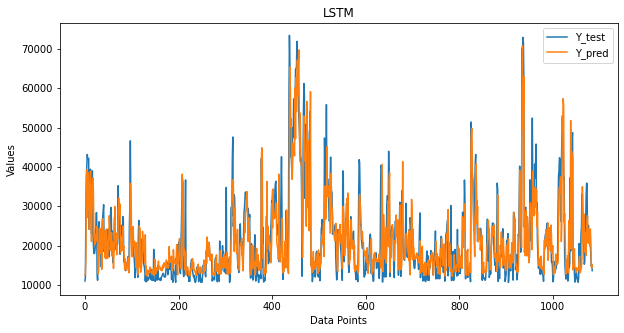

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

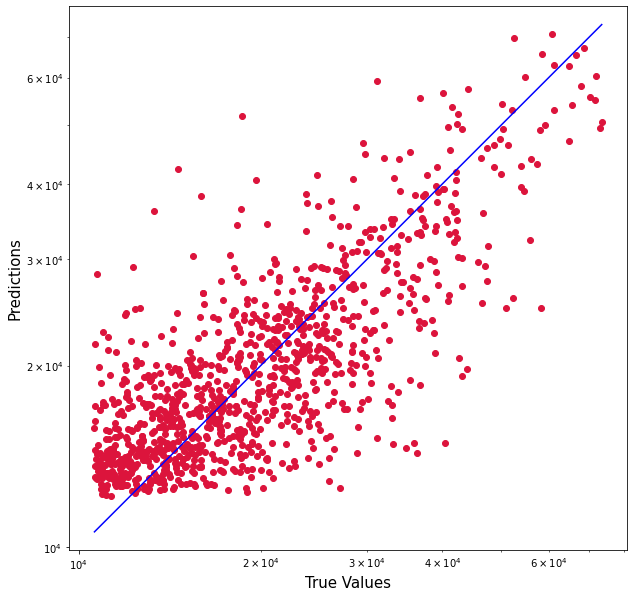

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

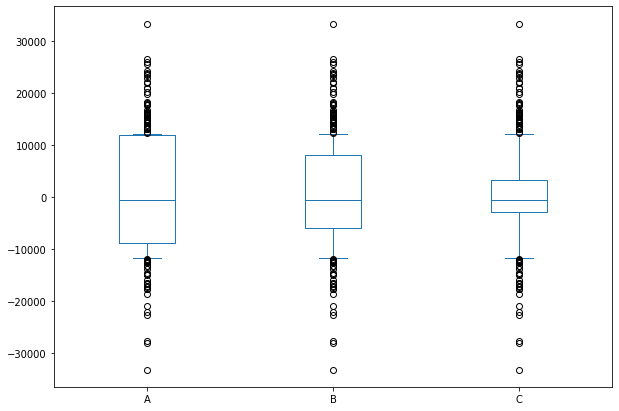

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,12453.583
1,12671.013
2,16945.232
3,34050.374
4,39274.876
...,...
1080,24217.000
1081,21472.443
1082,14659.267
1083,14305.061


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(4512.8125, shape=(), dtype=float64)
Decimal Representation: 4512.81250000000000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.21448938597129377
 0.21449


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.6728061848516982

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.4849001007860808

# Without Throughput Split

In [ ]:
frame.shape

(10639, 46)

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
3472,8.657,8.185,8.045,7.921,7.964,6565.000,6185.000,5679.000,4742.000,1800.000,...,6.621,6.094,5.949,6.051,139.000,149.000,133.000,84.000,33.000,4799.000
3291,5.000,2.000,2.000,6.000,6.000,9305.000,5457.000,3601.000,7325.000,5972.000,...,-8.000,-8.000,1.000,1.000,177.000,86.000,63.000,174.000,111.000,2896.000
10505,7.000,7.000,7.000,7.000,7.000,21506.000,15635.000,17234.000,25879.000,23821.000,...,4.000,4.000,2.000,2.000,429.000,303.000,328.000,511.000,501.000,19743.000
8726,8.000,8.000,8.000,8.000,8.000,6039.000,7101.000,25880.000,18243.000,8991.000,...,5.000,4.000,4.000,4.000,112.000,133.000,465.000,332.000,227.000,9575.000
4374,8.434,8.138,8.109,7.997,8.072,649.000,503.000,2303.000,1241.000,682.000,...,6.724,6.313,5.982,6.078,15.000,17.000,42.000,23.000,16.000,825.000


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.000,7.000,10.000,7.000,7.000,0.000,0.000,310.000,3.000,3.000,...,7.000,7.000,10.000,10.000,0.000,0.000,14.000,7.000,7.000,1769.000
2,7.000,7.000,7.000,7.000,10.000,0.000,0.000,0.000,0.000,310.000,...,8.000,8.000,7.000,7.000,0.000,0.000,0.000,0.000,14.000,2549.000
3,9.000,7.000,7.000,7.000,7.000,1757.000,0.000,0.000,0.000,0.000,...,10.000,8.000,8.000,7.000,68.000,0.000,0.000,0.000,0.000,2674.000
5,9.000,9.000,9.000,7.000,7.000,2874.000,4216.000,1757.000,0.000,0.000,...,10.000,10.000,10.000,8.000,53.000,151.000,68.000,0.000,0.000,2151.000
10,7.000,9.000,7.000,7.000,8.000,1666.000,2807.000,2382.000,1386.000,2516.000,...,9.000,9.000,12.000,10.000,60.000,52.000,45.000,26.000,47.000,2462.000


## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:15], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (5212, 15)
Validation set shape (2235, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2014,0.500,0.429,0.429,0.286,0.357,0.000,0.000,0.000,0.003,0.003,0.319,0.319,0.383,0.383,0.340
3568,0.571,0.500,0.500,0.500,0.500,0.391,0.187,0.294,0.316,0.248,0.426,0.426,0.426,0.426,0.426
2551,0.643,0.714,0.643,0.714,0.714,0.138,0.144,0.135,0.182,0.137,0.702,0.681,0.681,0.723,0.723
7071,0.714,0.714,0.714,0.429,0.429,0.023,0.010,0.014,0.014,0.005,0.532,0.468,0.468,0.511,0.511
575,0.540,0.508,0.497,0.495,0.507,0.087,0.081,0.058,0.045,0.057,0.493,0.458,0.451,0.449,0.452


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (5212, 15, 1)
Validation set shape (2235, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt3')


INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt3/oracle.json


INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt3/oracle.json


INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt3/tuner0.json


INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt3/tuner0.json


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 288
units2 160
units3 96
learning_rate 0.001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 288)               4608      
                                                                 
 dropout (Dropout)           (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               46240     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 96)                15456     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.06208454558061149
Validation rmse: 0.06369382852332267


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.643,0.429,0.429,0.000,0.000,0.004,0.000,0.000,0.489,0.468,0.468,0.532,0.532
1,0.429,0.429,0.429,0.429,0.643,0.000,0.000,0.000,0.000,0.004,0.532,0.489,0.489,0.468,0.468
2,0.571,0.429,0.429,0.429,0.429,0.022,0.000,0.000,0.000,0.000,0.532,0.532,0.489,0.489,0.468
3,0.571,0.571,0.571,0.429,0.429,0.036,0.048,0.021,0.000,0.000,0.532,0.532,0.532,0.532,0.489
4,0.429,0.571,0.429,0.429,0.500,0.021,0.032,0.028,0.016,0.032,0.489,0.511,0.511,0.574,0.532


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

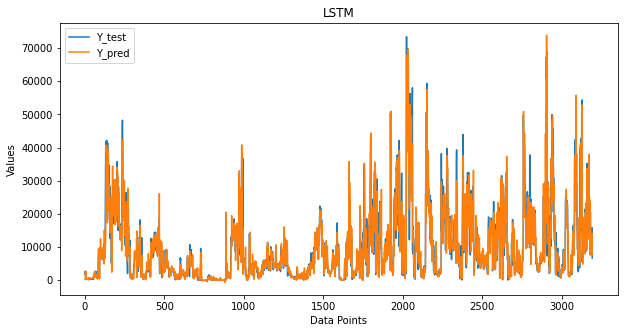

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

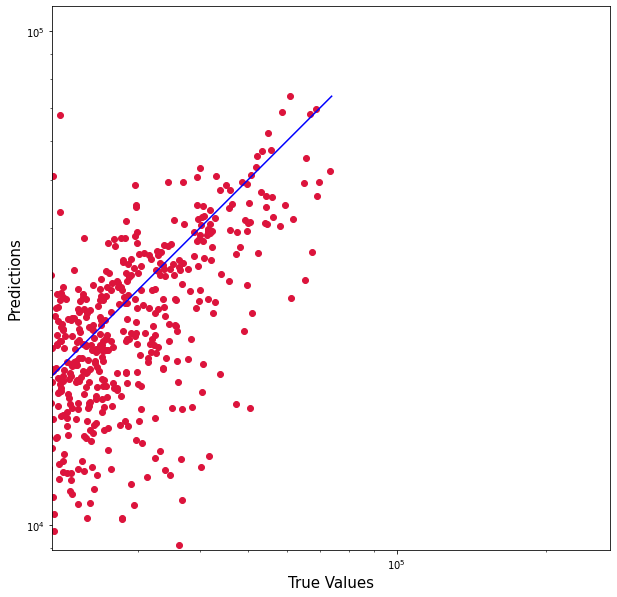

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

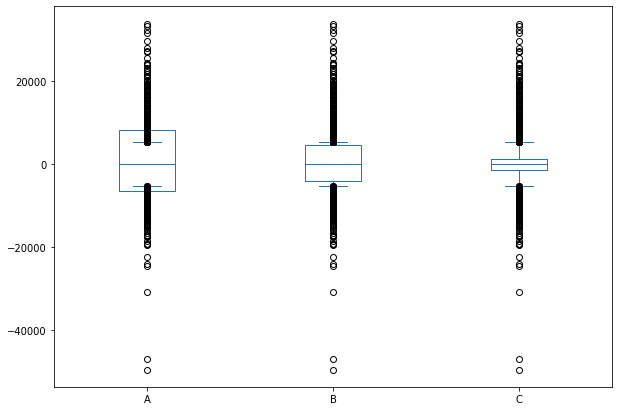

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2791.916015625, shape=(), dtype=float64)
Decimal Representation: 2791.91601562500000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

6.477265077131846e+16
 64772650771318464.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.365878932909307

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.23654130772385215

## Testing on SPlit Throughput

## Low Throughput

In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.643,0.429,0.429,0.000,0.000,0.013,0.000,0.000,0.676,0.647,0.647,0.735,0.758
1,0.571,0.429,0.429,0.429,0.429,0.118,0.000,0.000,0.000,0.000,0.735,0.735,0.676,0.676,0.667
2,0.429,0.500,0.571,0.571,0.571,0.093,0.121,0.123,0.150,0.060,0.794,0.735,0.735,0.735,0.758
3,0.429,0.429,0.429,0.571,0.429,0.258,0.053,0.071,0.100,0.081,0.676,0.676,0.676,0.706,0.727
4,0.429,0.571,0.571,0.571,0.571,0.007,0.015,0.047,0.006,0.074,0.647,0.647,0.706,0.706,0.758


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

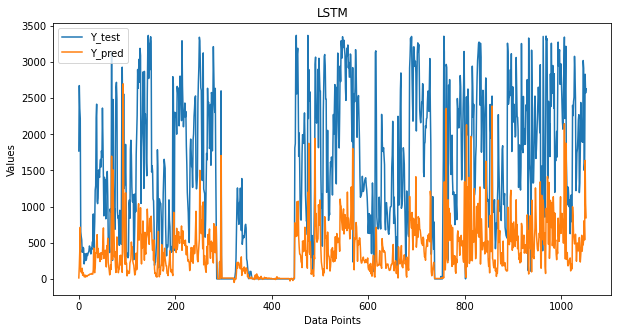

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

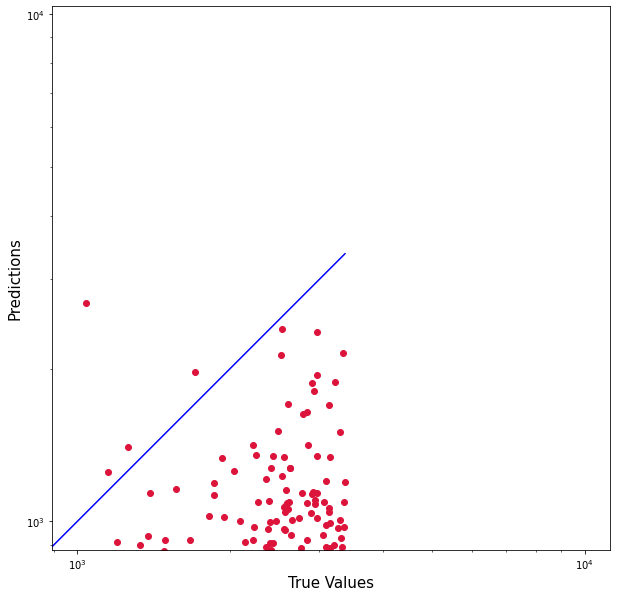

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

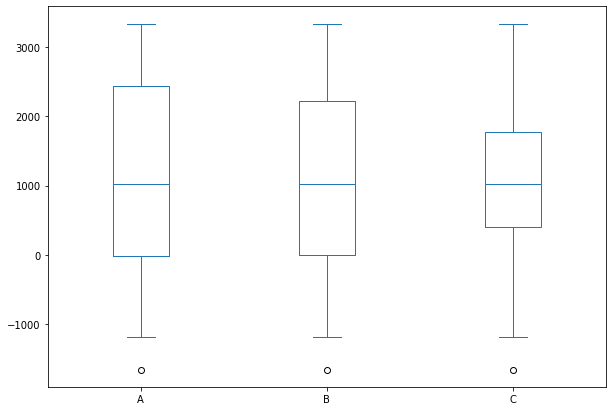

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,13.422
1,171.532
2,388.923
3,714.756
4,100.782
...,...
1048,805.160
1049,539.220
1050,1638.927
1051,1044.892


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(1099.3446044921875, shape=(), dtype=float64)
Decimal Representation: 1099.34460449218750000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

9341014977308934.0
 9341014977308934.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0021306952960396

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.414385045665864

## Medium Throughput

In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571,0.571,0.357,0.357,0.357,0.036,0.022,0.019,0.015,0.021,0.390,0.405,0.381,0.381,0.310
1,0.571,0.571,0.571,0.571,0.571,0.104,0.030,0.032,0.025,0.023,0.439,0.452,0.452,0.405,0.405
2,0.500,0.500,0.500,0.500,0.571,0.181,0.104,0.104,0.127,0.078,0.488,0.476,0.500,0.452,0.452
3,0.500,0.500,0.500,0.500,0.500,0.338,0.224,0.184,0.147,0.156,0.463,0.476,0.476,0.476,0.476
4,0.500,0.500,0.500,0.357,0.357,0.226,0.158,0.128,0.043,0.000,0.268,0.262,0.262,0.214,0.214


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

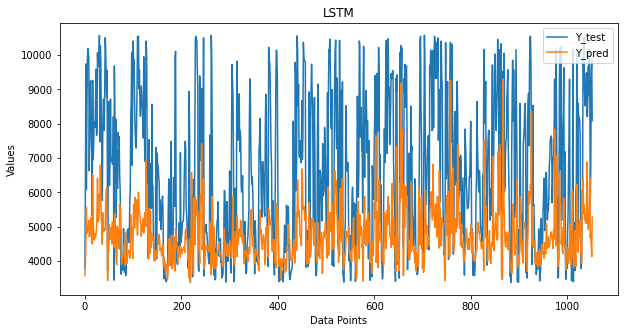

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

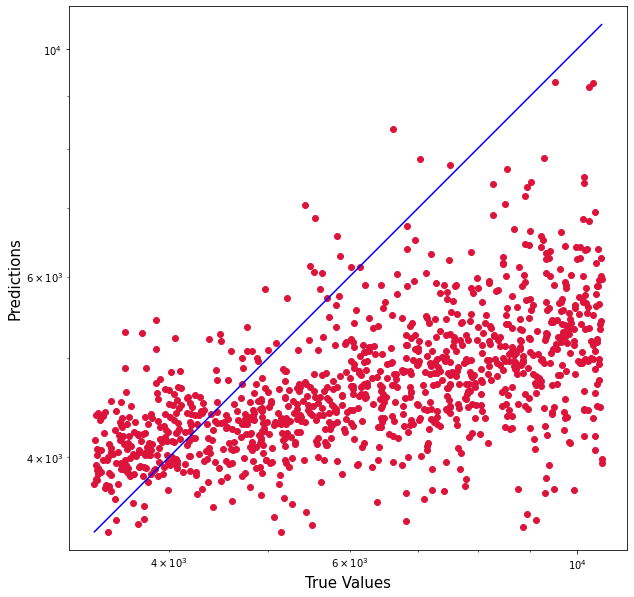

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

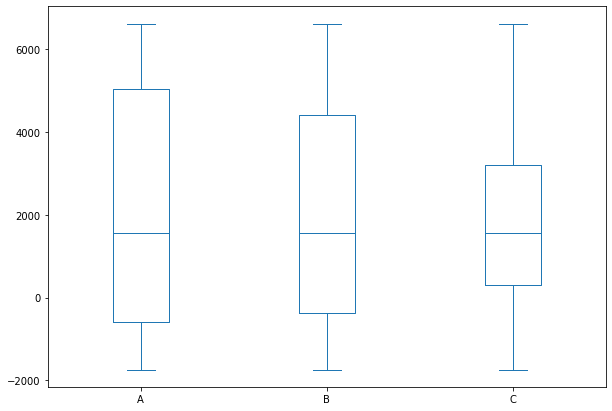

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,3580.297
1,3907.363
2,4561.917
3,5568.142
4,4817.661
...,...
1048,4684.360
1049,4819.254
1050,4428.795
1051,4131.603


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2003.3489990234375, shape=(), dtype=float64)
Decimal Representation: 2003.34899902343750000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.26263504625743905
 0.26264


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.071054060817677

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.6773458741387626

## High Throughput

In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.538,0.571,0.500,0.500,0.500,0.056,0.045,0.060,0.080,0.093,0.400,0.400,0.400,0.400,0.400
1,0.538,0.643,0.643,0.571,0.571,0.095,0.062,0.070,0.050,0.045,0.444,0.444,0.400,0.400,0.400
2,1.000,0.786,0.643,0.643,0.071,0.137,0.111,0.099,0.086,0.086,0.578,0.444,0.444,0.444,0.311
3,0.000,0.643,0.643,1.000,0.643,0.407,0.612,0.323,0.190,0.139,0.600,0.600,0.689,0.689,0.578
4,0.769,0.786,0.500,0.643,0.643,0.618,0.346,0.424,0.296,0.296,0.444,0.444,0.511,0.511,0.511


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

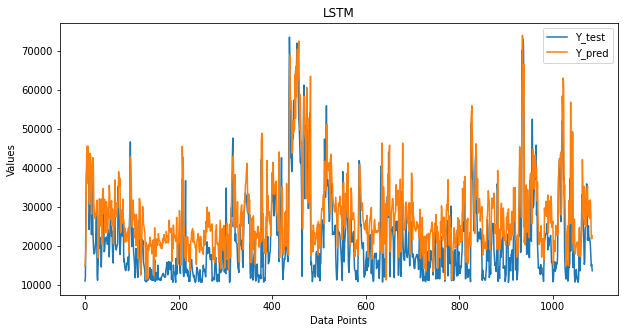

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

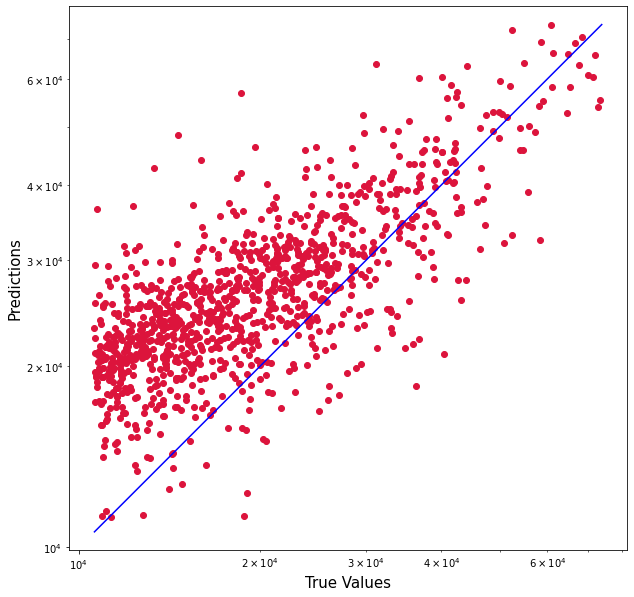

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

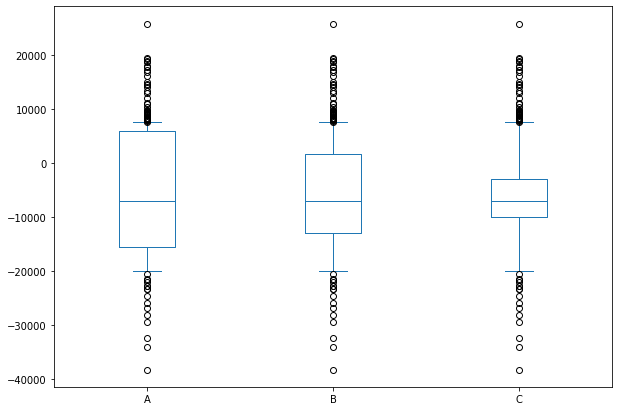

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,30105.426
1,39825.944
2,22053.146
3,18129.974
4,18331.526
...,...
2527,28145.516
2528,17140.932
2529,19859.291
2530,24238.222


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(7706.42724609375, shape=(), dtype=float64)
Decimal Representation: 7706.42724609375000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.4513642685906318
 0.45136


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0221939653147445

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.6500486086411552